**Import all required libraries**
===============================

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

from subprocess import check_output


Using TensorFlow backend.


**Load Train and Test data**
============================

In [2]:
# membuat training dan test set
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = (train.iloc[:,1:].values).astype('float32') # semua nilai pixel
y_train = train.iloc[:,0].values.astype('int32') # memberi label pada target digit
X_test = test.values.astype('float32')

In [5]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
y_train

array([1, 0, 1, ..., 7, 6, 9])

## Data Visualization (Coba Melihat 3 Gambar Dari Dataset dan Labelnya)

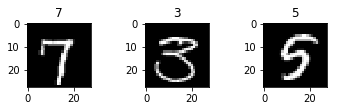

In [7]:
#mengkonversi train dataset ke format (num_images, img_rows, img_cols) 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [8]:
#mengekspansi 1 dimensi tambahan karena 1 dimensi sudah digunakan untuk grayscale
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [9]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

**Preprocessing the digit images**
==================================

**Feature Standardization (Melakukan Pre-Processing Data Untuk Memusatkan Data di Sekitar Angka 0 dan Unit Variansinya **
-------------------------------------

In [10]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

*One Hot encoding of labels (Merepresentasikan Kombinasi Angka Ke 10 Digit Kombinasi dan Angka 1 Sebagai Identifiernya.*
-----------------------------

In [11]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

C:\DevSoft\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


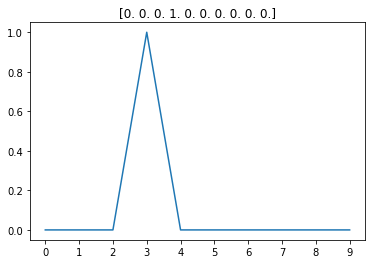

In [12]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

**Designing Neural Network Architecture**
=========================================

In [13]:
# Memperbaiki Random Seed
seed = 43
np.random.seed(seed)

*Linear Model (Membuat Model Sequential Keras Sederhana)*
--------------

In [14]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

In [15]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


***Compile network***
-------------------

In [16]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001), # untuk mengupdate network pada saat terjadi loss
 loss='categorical_crossentropy', # fungsi loss untuk mengukur bagus tidaknya network yang digunakan
 metrics=['accuracy']) # untuk memonitor performance dari network

In [17]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

## Cross Validation 

In [18]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [19]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
37800/37800 [==============================] - 119s 3ms/step - loss: 0.2407 - accuracy: 0.9338 - val_loss: 0.4029 - val_accuracy: 0.9120
Epoch 2/3
37800/37800 [==============================] - 119s 3ms/step - loss: 0.2169 - accuracy: 0.9410 - val_loss: 0.4642 - val_accuracy: 0.9109
Epoch 3/3
37800/37800 [==============================] - 118s 3ms/step - loss: 0.2114 - accuracy: 0.9428 - val_loss: 0.3597 - val_accuracy: 0.9088


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

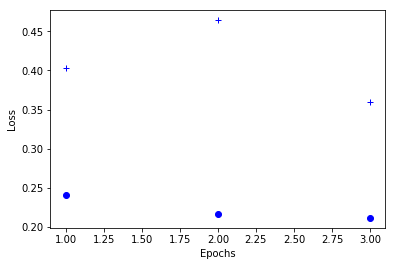

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

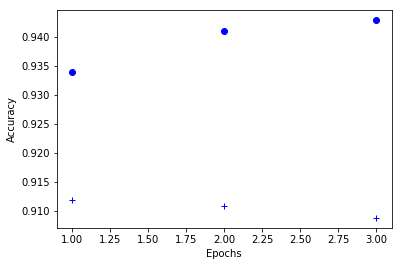

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

## Fully Connected Model (Menghubungkan Seluruh Layer Yang Sudah Dibentuk)

In [28]:
import keras
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
fc = get_fc_model()

In [30]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 146s 4ms/step - loss: 0.1187 - accuracy: 0.9762 - val_loss: 2.6619 - val_accuracy: 0.9579


## Convolutional Neural Network

In [31]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
model= get_cnn_model()

In [33]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 276s 7ms/step - loss: 0.0684 - accuracy: 0.9816 - val_loss: 0.8482 - val_accuracy: 0.9665


## Data Augmentation (Teknik Yang Digunakan Untuk Menghindari Overfitting)

In [34]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [36]:

history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 610s 16ms/step - loss: 0.1211 - accuracy: 0.9664 - val_loss: 0.0910 - val_accuracy: 0.9643


## Adding Batch Normalization (Melakukan Tuning Pada HyperParamater)

In [37]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
model= get_bn_model()
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 675s 18ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.0469 - val_accuracy: 0.9926


In [39]:
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

Epoch 1/3
42000/42000 [==============================] - 696s 17ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 2/3
42000/42000 [==============================] - 697s 17ms/step - loss: 8.0703e-04 - accuracy: 0.9998
Epoch 3/3
42000/42000 [==============================] - 696s 17ms/step - loss: 5.6661e-04 - accuracy: 0.9998


## Mengeksport Hasil Ke Dalam Bentuk CSV

In [40]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)